<a href="https://colab.research.google.com/github/anasnafis77/Deteksi-Glaukoma/blob/main/Glaucoma_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import random

In [3]:
path = '/content/gdrive/My Drive/Drive Tugas Akhir/Kode/'

In [4]:
df = pd.read_json(path+'dataframe_new.json')


In [6]:
VCDR_gtn = np.array(df['mean VCDR'].tolist())
gl_ix = df.index[df['tag']=='Glaucoma'].tolist()
n_ix = df.index[df['tag']=='Normal'].tolist()
dr_gl_ix = [x for x in gl_ix if x < 50]
re_gl_ix = [x for x in gl_ix if x >= 50]
dr_n_ix = [x for x in n_ix if x < 50]
re_n_ix = [x for x in n_ix if x >= 50]
print(len(dr_gl_ix)+len(dr_n_ix))
print(len(re_gl_ix)+len(re_n_ix))

50
400


In [5]:
def CDR_calc(OD_mask, OC_mask):
  try:
    c_OD,_ = cv2.findContours(OD_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    p_OD = cv2.approxPolyDP(c_OD[0], 3, True)
    c_OC,_ = cv2.findContours(OC_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    p_OC = cv2.approxPolyDP(c_OC[0], 3, True)
    x_OD, y_OD, hor_OD, ver_OD = cv2.boundingRect(p_OD)
    x_OC, y_OC, hor_OC, ver_OC = cv2.boundingRect(p_OC)
    

    VCDR = ver_OC/ver_OD # vertical CDR
    HCDR = hor_OC/ hor_OD # Horizontal CDR
    ACDR = np.sum(OC_mask == 255)/ np.sum(OD_mask == 255) # Area CDR


  except:
    VCDR = float("nan")
    HCDR = float("nan")
    ACDR = float("nan")
  
  return VCDR, HCDR, ACDR

In [110]:
# vertical CDR perhitungan mandiri pada mask gt
VCDR_gtm = []
VCDR_seg = []
VCDR_gtm = []
VCDR_seg = []
HCDR_gtm = []
HCDR_seg = []
ACDR_gtm = []
ACDR_seg = []
nan_ix = []
for i in tqdm(range(len(df))):
  OD_gt = cv2.imread(df['path_OD_png'][i], 0)
  OC_gt = cv2.imread(df['path_OC_png'][i], 0)
  OD_seg = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OD_{}.png'.format(i+1), 0)
  OC_seg = cv2.imread('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/Hasil segmentasi/semantic fixed/OC_{}.png'.format(i+1), 0)
  VCDR_gt, HCDR_gt, ACDR_gt = CDR_calc(OD_gt, OC_gt)
  VCDR_sg, HCDR_sg, ACDR_sg = CDR_calc(OD_seg, OC_seg)

  VCDR_gtm.append(VCDR_gt)
  VCDR_seg.append(VCDR_sg)
  HCDR_gtm.append(HCDR_gt)
  HCDR_seg.append(HCDR_sg)
  ACDR_gtm.append(ACDR_gt)
  ACDR_seg.append(ACDR_sg)
  if np.isnan(VCDR_sg):
    nan_ix.append(i)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [111]:
inf_df = pd.DataFrame({'VCDR Gold': VCDR_gtn, 'VCDR': VCDR_seg, 'HCDR': HCDR_seg, 
                       'ACDR': ACDR_seg, 'VCDR GT': VCDR_gtm, 'HCDR GT': HCDR_gtm,
                       'ACDR GT': ACDR_gtm, 'tag': df['tag'].tolist()})
inf_df.to_csv('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.csv')
inf_df.to_json('/content/gdrive/My Drive/Drive Tugas Akhir/Kode/inference_data.json')

In [112]:
inf_df

,VCDR Gold,VCDR,HCDR,ACDR,VCDR GT,HCDR GT,ACDR GT,tag
0,0.7675,0.721875,0.700000,0.502997,0.763975,0.708978,0.553771,Glaucoma
1,0.8275,0.817680,0.731638,0.601489,0.834734,0.811209,0.670667,Glaucoma
2,0.8900,0.876777,0.829327,0.732849,0.897619,0.869458,0.787130,Glaucoma
3,0.8750,0.845144,0.751445,0.637164,0.877778,0.827692,0.735088,Glaucoma
4,0.8900,0.888298,0.747283,0.666102,0.891304,0.794521,0.707949,Glaucoma
...,...,...,...,...,...,...,...,...
445,NaN,0.460916,0.500000,0.234875,0.459893,0.527439,0.246267,Normal
446,NaN,0.485531,0.508264,0.242572,0.428115,0.552419,0.238698,Normal
447,NaN,0.425397,0.474265,0.199563,0.447284,0.457143,0.205939,Normal
448,NaN,0.538182,0.697674,0.377244,0.547945,0.803828,0.417157,Normal


In [ ]:
def sorting_xy(x, y):  
  coor = list(zip(x, y))
  print(coor)
  coor.sort(key=lambda pair: pair[1])
  print(coor)
  xs, ys = zip(*coor)

  xs = list(xs)
  ys = list(ys)

  return xs, ys

Feature importance using Random forest

In [114]:
X = inf_df[['VCDR GT', 'HCDR GT', 'ACDR GT']].to_numpy()
y = inf_df['tag'].to_numpy()
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

print(X.shape)
print(y.shape)

(450, 3)
(450,)


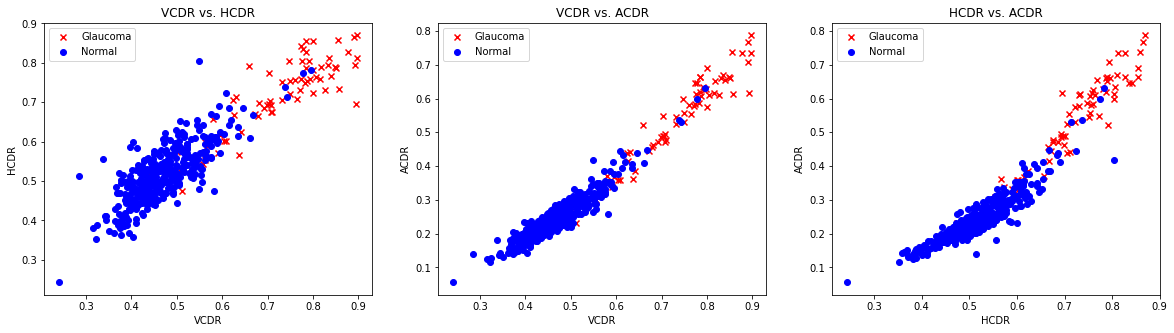

In [113]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'],
            marker='x', color ='r', label='Glaucoma')
ax[0].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'],
            marker='o', color ='b', label='Normal')
ax[0].set_title('VCDR vs. HCDR')
ax[0].set_xlabel('VCDR')
ax[0].set_ylabel('HCDR')
ax[0].legend()
ax[1].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT'],
            marker='x', color ='r', label='Glaucoma')
ax[1].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['VCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['ACDR GT'],
            marker='o', color ='b', label='Normal')
ax[1].set_title('VCDR vs. ACDR')
ax[1].set_xlabel('VCDR')
ax[1].set_ylabel('ACDR')
ax[1].legend()
ax[2].scatter(x=inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT'],
            marker='x', color ='r', label='Glaucoma')
ax[2].scatter(x=inf_df.loc[inf_df['tag']=='Normal']['HCDR GT'], 
            y=inf_df.loc[inf_df['tag']=='Normal']['ACDR GT'],
            marker='o', color ='b', label='Normal')
ax[2].set_title('HCDR vs. ACDR')
ax[2].set_xlabel('HCDR')
ax[2].set_ylabel('ACDR')
ax[2].legend()
plt.show()

In [115]:
def threshold_pred(CDRS, threshold):
  pred = []
  for CDR in CDRS:
    if CDR< threshold:
      pred.append('Normal')
    elif CDR>= threshold:
      pred.append('Glaucoma')
  pred = np.array(pred)
  return pred

In [116]:
import tensorflow as tf
y_pred = threshold_pred(inf_df['VCDR'], threshold=0.63)
y_pred = le.transform(y_pred)
acc_m = tf.keras.metrics.BinaryAccuracy()
acc_m.update_state(y_pred, y)
print(acc_m.result().numpy())

0.9355556


In [88]:
from sklearn import svm
# define the model
model = svm.SVC(kernel='linear')

# fit the model
model.fit(X, y)
# get importance

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance

plt.bar([1,2,3], importance)
plt.title('Tingkat kepentingan fitur glaukoma')
plt.ylabel('Tingkat kepentingan')
plt.xticks([1, 2, 3], labels=['VCDR', 'HCDR', 'ACDR'])
plt.show()

AttributeError: ignored

**GT number VCDR**

Absolute error in all cases: 0.00498
Absolute error in glaucoma cases: 0.00541
Absolute error in normal cases: 0.00473


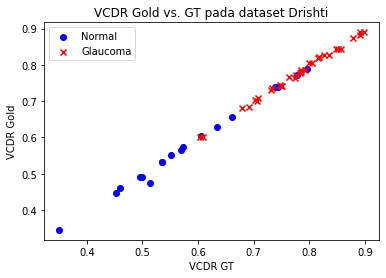

In [24]:
abs_e = np.sum(abs(inf_df['VCDR Gold'][:50]-inf_df['VCDR GT'][:50]))/ 50
xo = inf_df['VCDR GT'][dr_n_ix]
yo = inf_df['VCDR Gold'][dr_n_ix]
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df['VCDR GT'][dr_gl_ix]
yi = inf_df['VCDR Gold'][dr_gl_ix]
abs_e_re = np.sum(abs(xi-yi))/len(xi)
x = inf_df['VCDR GT']
y = inf_df['VCDR Gold']

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

plt.scatter(xo, yo, marker='o', color='b', label='Normal')
plt.scatter(xi, yi, marker='x', color='r', label='Glaucoma')
plt.ylabel('VCDR Gold')
plt.xlabel('VCDR GT')
plt.title('VCDR Gold vs. GT pada dataset Drishti')
plt.legend()
plt.show()

Absolute error in all cases: 0.03294
Absolute error in glaucoma cases: 0.03110
Absolute error in normal cases: 0.04260


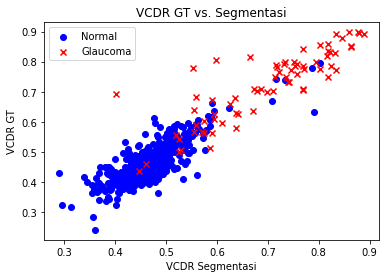

In [117]:
abs_e = np.sum(abs(inf_df['VCDR GT']-inf_df['VCDR']))/ len(inf_df['VCDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['VCDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['VCDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['VCDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

plt.scatter(xo, yo, marker='o', color='b', label='Normal')
plt.scatter(xi, yi, marker='x', color='r', label='Glaucoma')
plt.ylabel('VCDR GT')
plt.xlabel('VCDR Segmentasi')
plt.title('VCDR GT vs. Segmentasi')
plt.legend()
plt.show()

Absolute error in all cases: 0.03835
Absolute error in glaucoma cases: 0.03660
Absolute error in normal cases: 0.04757


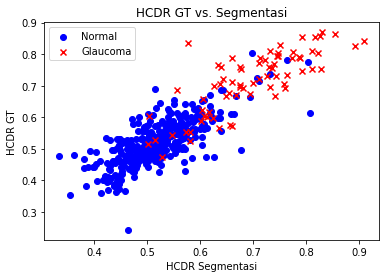

In [118]:
abs_e = np.sum(abs(inf_df['HCDR GT']-inf_df['HCDR']))/ len(inf_df['HCDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['HCDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['HCDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['HCDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

plt.scatter(xo, yo, marker='o', color='b', label='Normal')
plt.scatter(xi, yi, marker='x', color='r', label='Glaucoma')
plt.ylabel('HCDR GT')
plt.xlabel('HCDR Segmentasi')
plt.title('HCDR GT vs. Segmentasi')
plt.legend()
plt.show()

Absolute error in all cases: 0.02980
Absolute error in glaucoma cases: 0.02582
Absolute error in normal cases: 0.05070


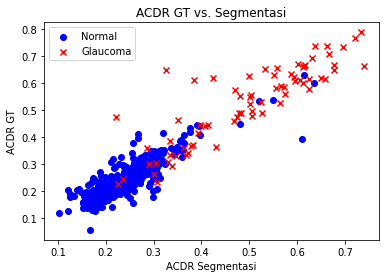

In [119]:
abs_e = np.sum(abs(inf_df['ACDR GT']-inf_df['ACDR']))/ len(inf_df['ACDR'])
xo = inf_df.loc[inf_df['tag']=='Normal']['ACDR']
yo = inf_df.loc[inf_df['tag']=='Normal']['ACDR GT']
abs_e_dr = np.sum(abs(xo-yo))/len(xo)
xi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR']
yi = inf_df.loc[inf_df['tag']=='Glaucoma']['ACDR GT']
abs_e_re = np.sum(abs(xi-yi))/len(xi)

print('Absolute error in all cases: {:.5f}'.format(abs_e))
print('Absolute error in glaucoma cases: {:.5f}'.format(abs_e_dr))
print('Absolute error in normal cases: {:.5f}'.format(abs_e_re))

plt.scatter(xo, yo, marker='o', color='b', label='Normal')
plt.scatter(xi, yi, marker='x', color='r', label='Glaucoma')
plt.ylabel('ACDR GT')
plt.xlabel('ACDR Segmentasi')
plt.title('ACDR GT vs. Segmentasi')
plt.legend()
plt.show()

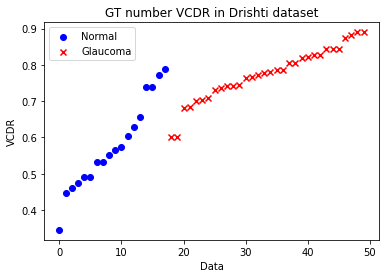

In [ ]:
xo = list(range(len(dr_n_ix)))
yo = sorted(VCDR_gtn[dr_n_ix].tolist())
# xo, yo = sorting_xy(xo, yo)

xi = list(range(len(xo), len(dr_gl_ix)+len(xo)))
yi = sorted(VCDR_gtn[dr_gl_ix].tolist())
#xi, yi = sorting_xy(xi, yi)

plt.scatter(xo, yo, marker='o', color='b', label='Normal')
plt.scatter(xi, yi, marker='x', color='r', label='Glaucoma')
plt.ylabel('VCDR')
plt.xlabel('Data')
plt.title('GT number VCDR in Drishti dataset')
plt.legend()
plt.show()

**GT Mask VCDR**

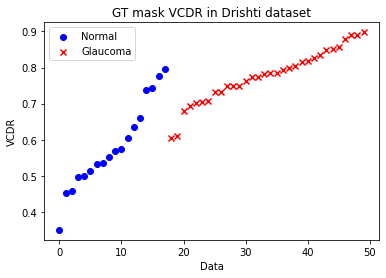

In [ ]:
xo = list(range(len(dr_n_ix)))
yo = sorted(VCDR_gtm[dr_n_ix].tolist())

xi = list(range(len(xo), len(dr_gl_ix)+len(xo)))
yi = sorted(VCDR_gtm[dr_gl_ix].tolist())

plt.scatter(xo, yo, marker='o', color='b', label='Normal')
plt.scatter(xi, yi, marker='x', color='r', label='Glaucoma')
plt.ylabel('VCDR')
plt.xlabel('Data')
plt.title('GT mask VCDR in Drishti dataset')
plt.legend()
plt.show()

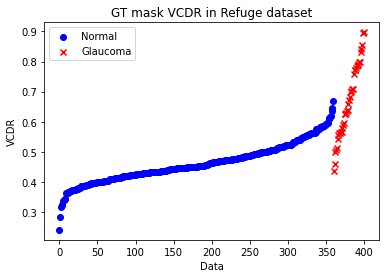

In [ ]:
xo = list(range(len(re_n_ix)))
yo = sorted(VCDR_gtm[re_n_ix].tolist())

xi = list(range(len(xo), len(re_gl_ix)+len(xo)))
yi = sorted(VCDR_gtm[re_gl_ix].tolist())

plt.scatter(xo, yo, marker='o', color='b', label='Normal')
plt.scatter(xi, yi, marker='x', color='r', label='Glaucoma')
plt.ylabel('VCDR')
plt.xlabel('Data')
plt.title('GT mask VCDR in Refuge dataset')
plt.legend()
plt.show()

**Segmentation VCDR**

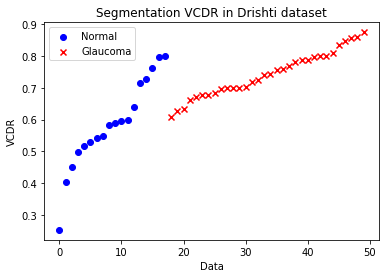

In [ ]:
yo = [x for x in VCDR_seg[dr_n_ix] if np.isnan(x) == False]
yo = sorted(yo)
xo = list(range(len(yo)))

yi = [x for x in VCDR_seg[dr_gl_ix] if np.isnan(x) == False]
yi = sorted(yi)
xi = list(range(len(xo), len(xo) + len(yi)))

plt.scatter(xo, yo, marker='o', color='b', label='Normal')
plt.scatter(xi, yi, marker='x', color='r', label='Glaucoma')
plt.ylabel('VCDR')
plt.xlabel('Data')
plt.title('Segmentation VCDR in Drishti dataset')
plt.legend()
plt.show()

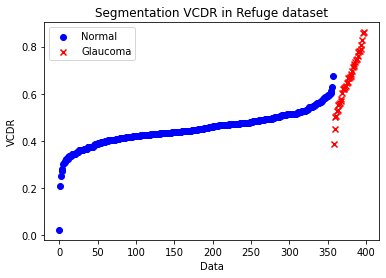

In [ ]:
yo = [x for x in VCDR_seg[re_n_ix] if np.isnan(x) == False]
yo = sorted(yo)
xo = list(range(len(yo)))

yi = [x for x in VCDR_seg[re_gl_ix] if np.isnan(x) == False]
yi = sorted(yi)
xi = list(range(len(xo), len(xo) + len(yi)))

plt.scatter(xo, yo, marker='o', color='b', label='Normal')
plt.scatter(xi, yi, marker='x', color='r', label='Glaucoma')
plt.ylabel('VCDR')
plt.xlabel('Data')
plt.title('Segmentation VCDR in Refuge dataset')
plt.legend()
plt.show()

**Limit of Agreement**

GT number vs. GT mask

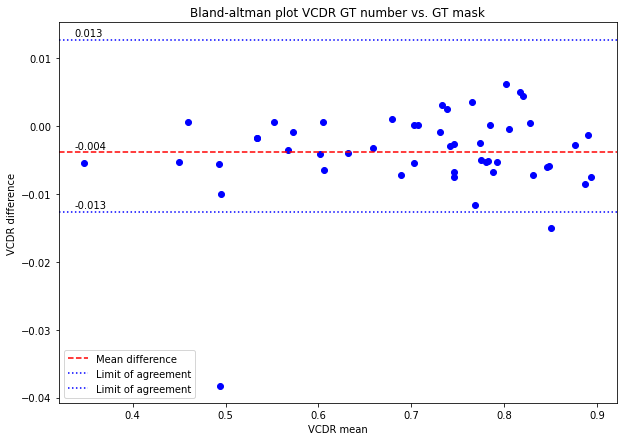

In [ ]:
gtn = [x for x in VCDR_gtn if not np.isnan(x)]
gtm = VCDR_gtm[:50]
diff = gtn - gtm
rata2 = (gtn + gtm) /2
mean = np.mean(diff)
std = np.std(diff)
plt.figure(figsize=(10,7))
plt.scatter(rata2, diff, color='b')
plt.axhline(mean, color = 'r', linestyle = '--', label = 'Mean difference')
plt.axhline(1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(-1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.text(np.min(rata2) - 0.01, mean + 0.0005, '{:.3f}'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, 1.95*std  + 0.0005, '{:.3f}'.format(1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, -1.95*std + 0.0005, '{:.3f}'.format(-1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot VCDR GT number vs. GT mask')
plt.ylabel('VCDR difference')
plt.xlabel('VCDR mean')
plt.show()

GT mask vs. Segmentation

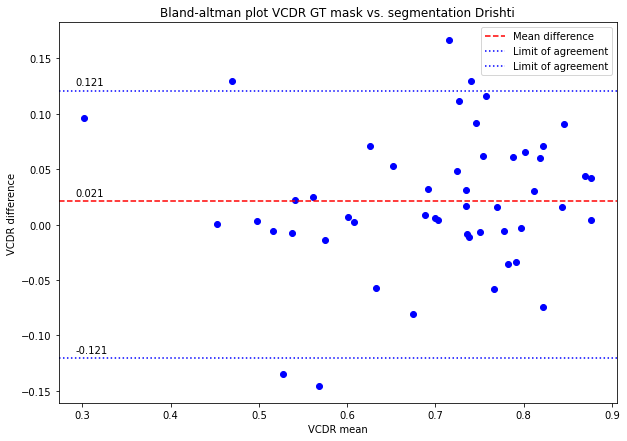

In [26]:
val1 = inf_df['VCDR GT'][:50]
val2 = inf_df['VCDR'][:50]
diff = val1 - val2
rata2 = (val1 + val2) /2
mean = np.mean(diff)
std = np.std(diff)
plt.figure(figsize=(10,7))
plt.scatter(rata2, diff, color='b')
plt.axhline(mean, color = 'r', linestyle = '--', label = 'Mean difference')
plt.axhline(1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(-1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.text(np.min(rata2) - 0.01, mean + 0.005, '{:.3f}'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, 1.95*std  + 0.005, '{:.3f}'.format(1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, -1.95*std + 0.005, '{:.3f}'.format(-1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot VCDR GT mask vs. segmentation Drishti')
plt.ylabel('VCDR difference')
plt.xlabel('VCDR mean')
plt.show()

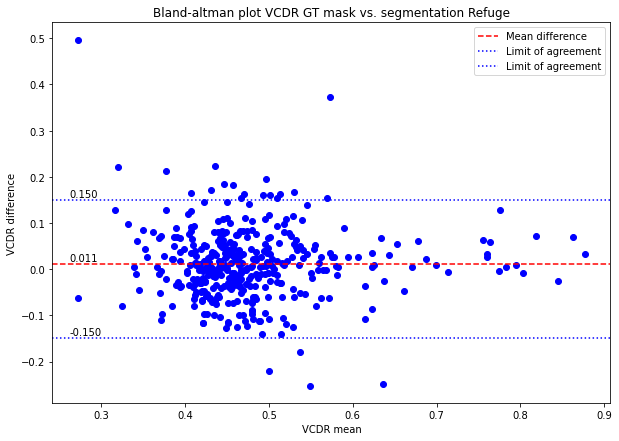

In [28]:
val1 = inf_df['VCDR GT'][50:]
val2 = inf_df['VCDR'][50:]
diff = val1 - val2
diff = val1 - val2
rata2 = (val1 + val2) /2
mean = np.mean(diff)
std = np.std(diff)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff, color='b')
plt.axhline(mean, color = 'r', linestyle = '--', label = 'Mean difference')
plt.axhline(1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(-1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.text(np.min(rata2) - 0.01, mean + 0.007, '{:.3f}'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, 1.95*std  + 0.007, '{:.3f}'.format(1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, -1.95*std + 0.007, '{:.3f}'.format(-1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot VCDR GT mask vs. segmentation Refuge')
plt.ylabel('VCDR difference')
plt.xlabel('VCDR mean')
plt.show()

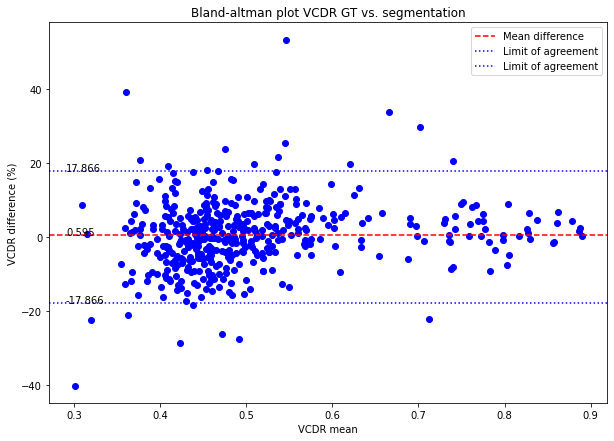

In [120]:
val1 = inf_df['VCDR GT']
val2 = inf_df['VCDR']
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff_p, color='b')
plt.axhline(mean, color = 'r', linestyle = '--', label = 'Mean difference')
plt.axhline(1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(-1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.text(np.min(rata2) - 0.01, mean + 0.007, '{:.3f}'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, 1.95*std  + 0.007, '{:.3f}'.format(1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, -1.95*std + 0.007, '{:.3f}'.format(-1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot VCDR GT vs. segmentation')
plt.ylabel('VCDR difference (%)')
plt.xlabel('VCDR mean')
plt.show()

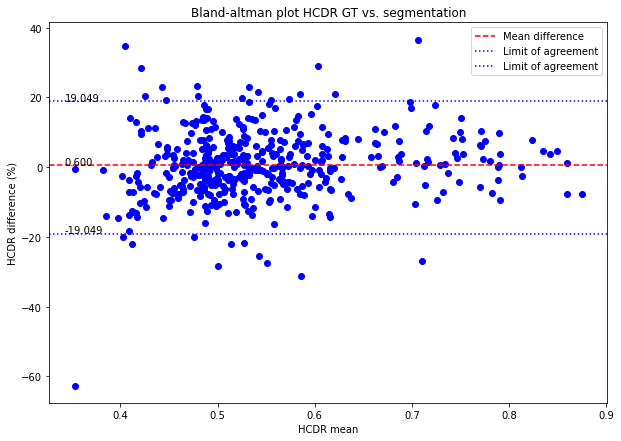

In [121]:
val1 = inf_df['HCDR GT']
val2 = inf_df['HCDR']
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff_p, color='b')
plt.axhline(mean, color = 'r', linestyle = '--', label = 'Mean difference')
plt.axhline(1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(-1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.text(np.min(rata2) - 0.01, mean + 0.007, '{:.3f}'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, 1.95*std  + 0.007, '{:.3f}'.format(1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, -1.95*std + 0.007, '{:.3f}'.format(-1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot HCDR GT vs. segmentation')
plt.ylabel('HCDR difference (%)')
plt.xlabel('HCDR mean')
plt.show()

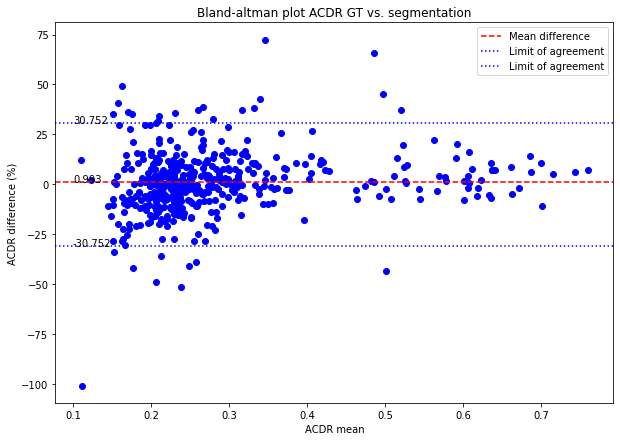

In [122]:
val1 = inf_df['ACDR GT']
val2 = inf_df['ACDR']
diff = val1 - val2
rata2 = (val1 + val2) /2
diff_p = np.divide(diff, rata2)*100
mean = np.mean(diff_p)
std = np.std(diff_p)

plt.figure(figsize=(10,7))
plt.scatter(rata2, diff_p, color='b')
plt.axhline(mean, color = 'r', linestyle = '--', label = 'Mean difference')
plt.axhline(1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(-1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.text(np.min(rata2) - 0.01, mean + 0.007, '{:.3f}'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, 1.95*std  + 0.007, '{:.3f}'.format(1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, -1.95*std + 0.007, '{:.3f}'.format(-1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot ACDR GT vs. segmentation')
plt.ylabel('ACDR difference (%)')
plt.xlabel('ACDR mean')
plt.show()

GT number vs. Segmentation

In [ ]:
val1 = [x for x in VCDR_gtn if not np.isnan(x)]
val2 = VCDR_seg[:50]
diff = val1 - val2
rata2 = (val1 + val2) /2
mean = np.mean(diff)
std = np.std(diff)
plt.figure(figsize=(10,7))
plt.scatter(rata2, diff, color='b')
plt.axhline(mean, color = 'r', linestyle = '--', label = 'mean difference')
plt.axhline(1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.axhline(-1.95*std, color = 'b', linestyle = ':', label = 'Limit of agreement')
plt.text(np.min(rata2) - 0.01, mean + 0.002, '{:.3f}'.format(mean), size='medium')
plt.text(np.min(rata2)- 0.01, 1.95*std  + 0.002, '{:.3f}'.format(1.95*std), size='medium')
plt.text(np.min(rata2)- 0.01, -1.95*std + 0.002, '{:.3f}'.format(-1.95*std), size='medium')
plt.legend()
plt.title('Bland-altman plot VCDR GT mask vs. segmentation Drishti')
plt.ylabel('VCDR difference')
plt.xlabel('VCDR mean')
plt.show()

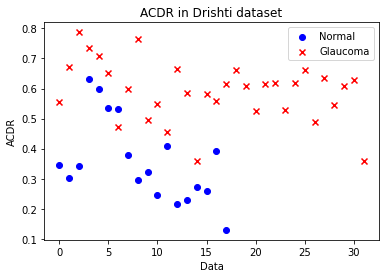

In [ ]:
plt.scatter(range(len(dr.loc[dr['tag']=='Normal'])), ACDR_gt[dr.index[dr['tag']=='Normal'].tolist()], marker='o', color='b', label='Normal')
plt.scatter( range(len(dr.loc[dr['tag']=='Glaucoma'])), ACDR_gt[dr.index[dr['tag']=='Glaucoma'].tolist()], marker='x', color='r', label='Glaucoma')
plt.ylabel('ACDR')
plt.xlabel('Data')
plt.title('ACDR in Drishti dataset')
plt.legend()
plt.show()

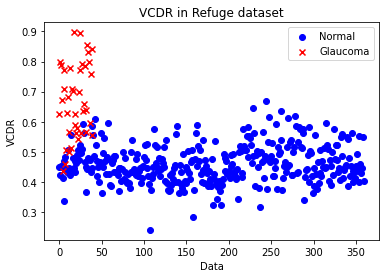

In [ ]:
plt.scatter(range(len(re.loc[re['tag']=='Normal'])), VCDR_gt[re.index[re['tag']=='Normal'].tolist()], marker='o', color='b', label='Normal')
plt.scatter( range(len(re.loc[re['tag']=='Glaucoma'])),VCDR_gt[re.index[re['tag']=='Glaucoma'].tolist()], marker='x', color='r', label='Glaucoma')
plt.ylabel('VCDR')
plt.xlabel('Data')
plt.title('VCDR in Refuge dataset')
plt.legend()
plt.show()

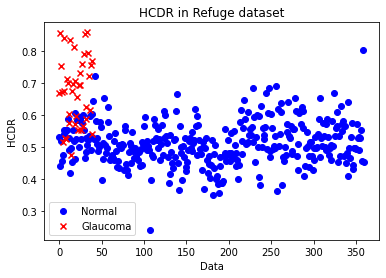

In [ ]:
plt.scatter(range(len(re.loc[re['tag']=='Normal'])), HCDR_gt[re.index[re['tag']=='Normal'].tolist()], marker='o', color='b', label='Normal')
plt.scatter( range(len(re.loc[re['tag']=='Glaucoma'])),HCDR_gt[re.index[re['tag']=='Glaucoma'].tolist()], marker='x', color='r', label='Glaucoma')
plt.ylabel('HCDR')
plt.xlabel('Data')
plt.title('HCDR in Refuge dataset')
plt.legend()
plt.show()

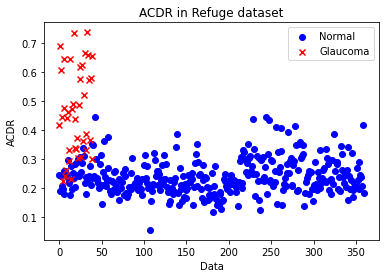

In [ ]:
plt.scatter(range(len(re.loc[re['tag']=='Normal'])), ACDR_gt[re.index[re['tag']=='Normal'].tolist()], marker='o', color='b', label='Normal')
plt.scatter( range(len(re.loc[re['tag']=='Glaucoma'])),ACDR_gt[re.index[re['tag']=='Glaucoma'].tolist()], marker='x', color='r', label='Glaucoma')
plt.ylabel('ACDR')
plt.xlabel('Data')
plt.title('ACDR in Refuge dataset')
plt.legend()
plt.show()